<a href="https://colab.research.google.com/github/hvr2026/AI_to_do_DataScience/blob/main/List_of_Orders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install necessary packages
!pip install pandas matplotlib scikit-learn statsmodels pmdarima seaborn




  Using cached pmdarima-2.0.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl.metadata (7.8 kB)
Using cached pmdarima-2.0.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl (2.1 MB)


In [15]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans

# Load the dataset (assuming it's uploaded to Colab)
from google.colab import files





In [16]:
# Load dataset from uploaded file (replace 'List_of_Orders.csv' with your filename)
data = pd.read_csv('/content/List_of_Orders.csv')

In [17]:
# 1. Data Quality & Missing Values Handling
# Preprocessing: Fixing date formats and handling missing values
data['Order Date'] = pd.to_datetime(data['Order Date'], errors='coerce')

# Forward-fill missing dates to maintain continuity for time series analysis
data['Order Date'].fillna(method='ffill', inplace=True)

# Group by 'Order Date' to get the number of orders per day
orders_per_day = data.groupby('Order Date').size()


<ipython-input-17-251c5e459cde>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Order Date'].fillna(method='ffill', inplace=True)
<ipython-input-17-251c5e459cde>:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['Order Date'].fillna(method='ffill', inplace=True)


In [19]:
# 2. ADF Test for Stationarity
def adf_test(timeseries):
    """Perform the Augmented Dickey-Fuller test to check for stationarity."""
    result = adfuller(timeseries)
    return result[1]  # Return the p-value

# Apply ADF test to see if differencing is needed
p_value = adf_test(orders_per_day)

# 3. Differencing to Make the Series Stationary
if p_value > 0.05:
    orders_per_day_diff = orders_per_day.diff().dropna()  # Apply differencing
    print("Applied differencing to make series stationary.")
else:
    orders_per_day_diff = orders_per_day  # No differencing needed
    print("Series is stationary, no differencing applied.")

Series is stationary, no differencing applied.


In [20]:

# 4. Train-Test Split
# Split the data into train (80%) and test (20%) sets
train_size = int(len(orders_per_day_diff) * 0.8)
train, test = orders_per_day_diff[:train_size], orders_per_day_diff[train_size:]

In [22]:
# 5. Auto ARIMA with Seasonal Parameter (SARIMA)
# Use auto_arima with seasonal parameter for better handling of seasonality
model = auto_arima(train, seasonal=True, m=6,  # Adjusting 'm' for seasonality
                   trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)

# Print the model summary
print(model.summary())



Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[6] intercept   : AIC=596.524, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[6] intercept   : AIC=614.592, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[6] intercept   : AIC=612.993, Time=0.07 sec
 ARIMA(0,1,1)(0,0,1)[6] intercept   : AIC=599.394, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[6]             : AIC=612.593, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[6] intercept   : AIC=595.362, Time=0.18 sec
 ARIMA(2,1,2)(0,0,0)[6] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(2,1,2)(0,0,2)[6] intercept   : AIC=596.396, Time=0.36 sec
 ARIMA(2,1,2)(1,0,0)[6] intercept   : AIC=596.917, Time=0.20 sec
 ARIMA(2,1,2)(1,0,2)[6] intercept   : AIC=598.395, Time=0.62 sec
 ARIMA(1,1,2)(0,0,1)[6] intercept   : AIC=593.350, Time=0.21 sec
 ARIMA(1,1,2)(0,0,0)[6] intercept   : AIC=593.367, Time=0.17 sec
 ARIMA(1,1,2)(1,0,1)[6] intercept   : AIC=594.360, Time=0.31 sec
 ARIMA(1,1,2)(0,0,2)[6] intercept   : AIC=594.168, Time=0.28 sec
 ARIMA(1,1,2)(1,0,0)[6] intercept   : AIC=593.817, 

In [29]:
# 6. Forecasting
# Forecast on test data
forecast = model.predict(n_periods=len(test))



/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [24]:
# 7. Calculate Performance Metrics
mae = mean_absolute_error(test, forecast)
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)

# Print performance metrics
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

Mean Absolute Error (MAE): 7.64420572632438
Mean Squared Error (MSE): 158.6249952572686
Root Mean Squared Error (RMSE): 12.594641529526301


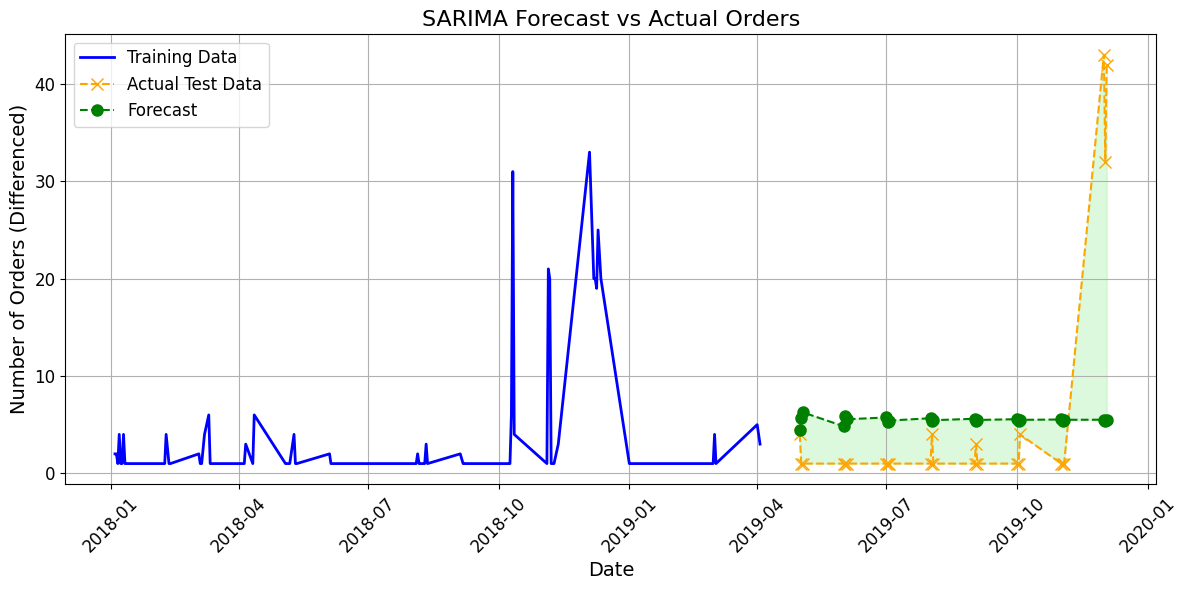

In [25]:
# 8. Plotting Forecast vs Actual Data
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Training Data', color='blue', linewidth=2)
plt.plot(test.index, test, label='Actual Test Data', color='orange', linestyle='--', marker='x', markersize=8)
plt.plot(test.index, forecast, label='Forecast', color='green', linestyle='--', marker='o', markersize=8)
plt.fill_between(test.index, test, forecast, color='lightgreen', alpha=0.3)  # Highlighting forecast error
plt.title('SARIMA Forecast vs Actual Orders', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Number of Orders (Differenced)', fontsize=14)
plt.legend(loc='upper left', fontsize=12)
plt.grid(True)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

In [26]:

# 9. Customer Segmentation using K-Means Clustering
# Encode categorical variables for clustering
le_state = LabelEncoder()
data['State'] = le_state.fit_transform(data['State'])

# Group by state and city to get the average order count
customer_data = data.groupby(['City', 'State']).size().reset_index(name='Order Count')

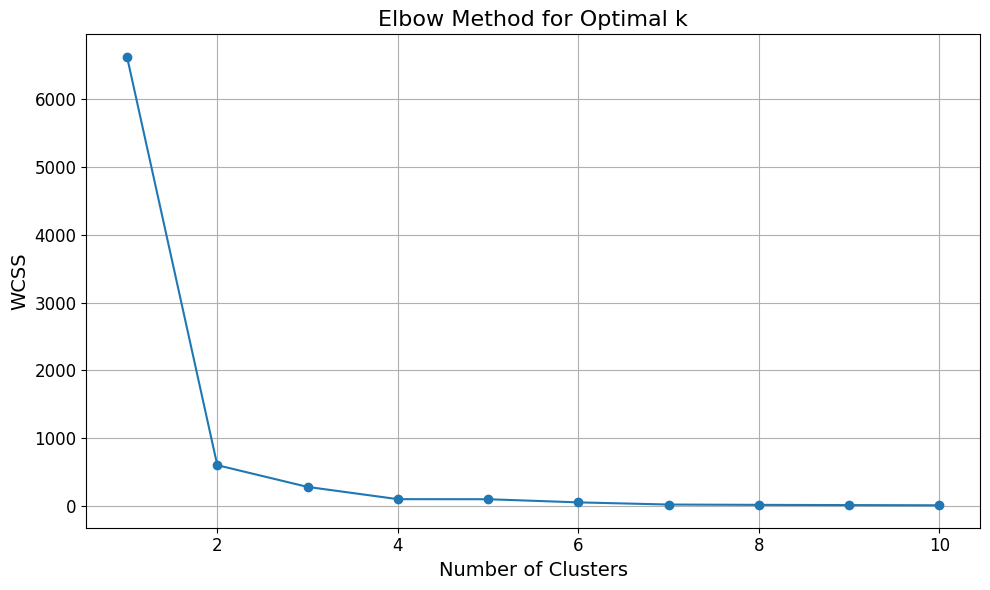

In [27]:
# 10. Elbow Method for Optimal Clusters
wcss = []  # Within-cluster sum of squares
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(customer_data[['Order Count']])
    wcss.append(kmeans.inertia_)

# Plotting the Elbow Method
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal k', fontsize=16)
plt.xlabel('Number of Clusters', fontsize=14)
plt.ylabel('WCSS', fontsize=14)
plt.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# Based on the elbow method, choose optimal clusters (example: k=3)
optimal_clusters = 3
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
customer_data['Cluster'] = kmeans.fit_predict(customer_data[['Order Count']])

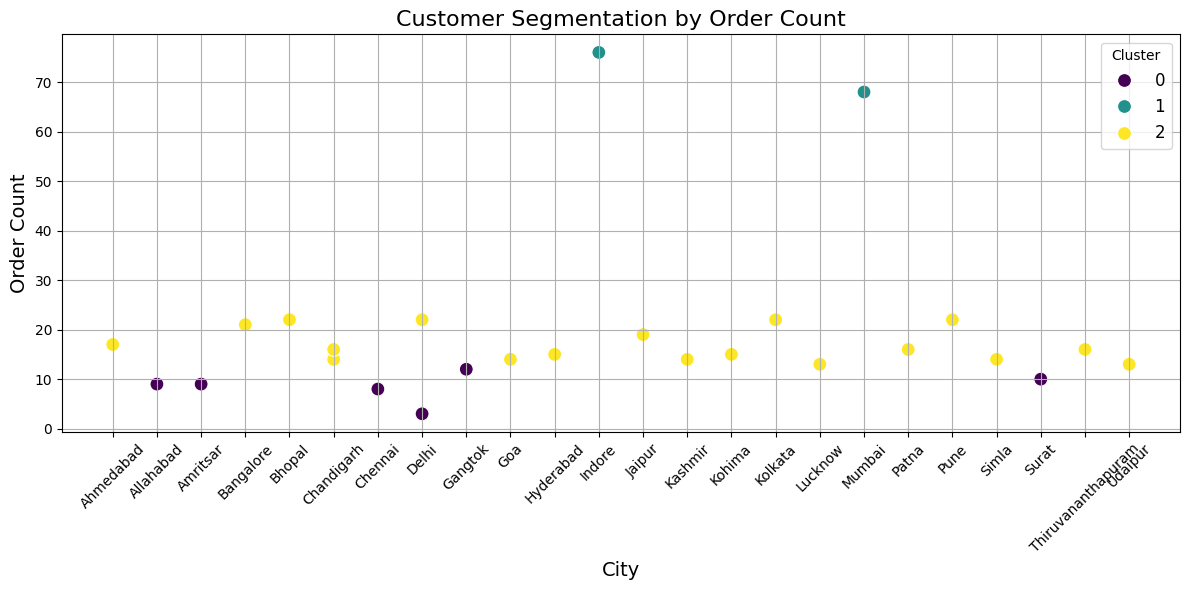

In [28]:
# 11. Visualizing Customer Segments
plt.figure(figsize=(12, 6))
sns.scatterplot(data=customer_data, x='City', y='Order Count', hue='Cluster', palette='viridis', s=100)
plt.title('Customer Segmentation by Order Count', fontsize=16)
plt.xlabel('City', fontsize=14)
plt.ylabel('Order Count', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Cluster', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()